In [2]:
# Dependencies - General Stuff
import sys
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit


# strfpy
import importlib
from module.strfpy.makePSTH import SpikeResponse
from module.strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep, calcSegmentedModel
from module.strfpy.timeFreq import timefreq_raw
from soundsig.sound import spec_colormap
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt

import pynwb
from matplotlib import pyplot as plt
# %matplotlib widget
plt.ion()

In [3]:
# nwb_file = '/aquila_ssd2/lthomas/songephys_data/OperantEphys/HpiPur2667F/sites/HpiPur2667F_site02_240905_072851_pb_op/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'

nwb_file = '/Users/frederictheunissen/Working Data/OperantEphys/NWB_Files/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'
# Load the nwb file
preprocOptions = {} # we'll leave this empty and use default options
nwb_io =  pynwb.NWBHDF5IO(nwb_file, mode='r')
nwb = nwb_io.read()
units = nwb.units.to_dataframe()
# load the good units
good_units = units[units.group == 'good']


In [4]:
# sample a random unit
unit = good_units.sample().iloc[0]
unit = good_units.loc[73]
print("Processing unit: ", unit.name)

Processing unit:  73


In [5]:
def get_mic_data(nwb, trial):
    rate = nwb.acquisition['audio'].rate
    mic_data = nwb.acquisition['audio'].data
    start_id = int(trial.start_time * rate)
    end_id = int(trial.stop_time * rate)
    mic_trial = mic_data[start_id:end_id]
    return mic_trial[:,1], mic_trial[:,0]

In [6]:
# lets take one trial and compare the spectrogram to the spectrogram of the microphone data
# lets get a ranodm trial
trials = nwb.intervals['playback_trials'].to_dataframe()

### Plot the stim and microphone data of a random playback trial
Run this cell again to see another example

A colormap named "SpectroColorMap" is already registered.


Text(0.5, 0, 'Time (s)')

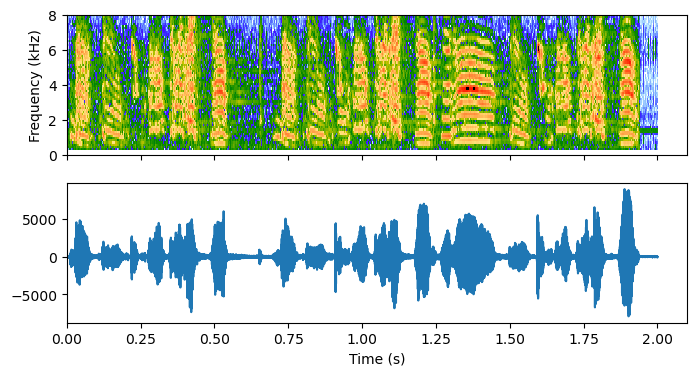

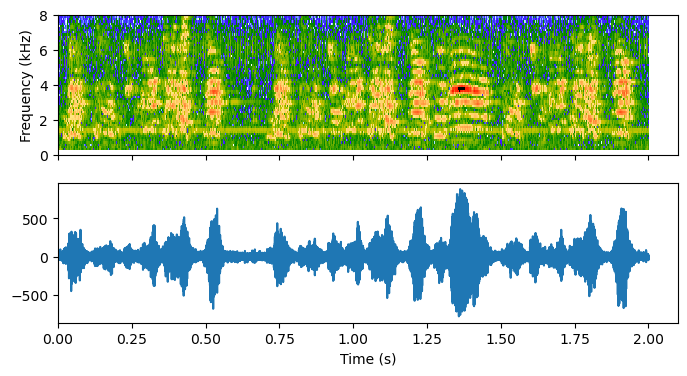

In [7]:
# Choose a ramdom trial
trial = trials.sample().iloc[0]
mic_trial, mic_copy = get_mic_data(nwb, trial)
rate = nwb.acquisition['audio'].rate

# Spectrogram paramteters.
stim_params = {}
stim_params['fband'] = 120
stim_params['nstd'] = 6
stim_params['high_freq'] = 8000
stim_params['low_freq'] = 250
stim_params['log'] = 1
stim_params['stim_rate'] = 1000  # Sample rate of spectrogram
DBNOISE = 80
# Colormap for plotting spectrograms
spec_colormap()   # defined in sound.py


# First figure for the microphone copy
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_copy, rate, 'ft', params=stim_params)
cmap = plt.get_cmap('SpectroColorMap')

minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_copy))/rate
ax2.plot(tval, mic_copy)
ax2.set_xlabel('Time (s)')

# Second copy for the microphone 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_trial, rate, 'ft', params=stim_params)
minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_trial))/rate
ax2.plot(tval, mic_trial)
ax2.set_xlabel('Time (s)')



#### Create an stimulus-response data set (srData) per stimlus

In [8]:
# Preprocess sound stimulus and segment

respChunkLen = 100 # ms of stim to use in each chunk of feature space
segmentBuffer = 30 # ms to add at the beginning of each segment
nLaguerre = 25 # number of laguerre functions to use
feature = 'spect_windows'
event_types = 'onoff_feature'
nPoints = 150 # number of points to use in the kernel
mult_values = False
srData = preprocSound.preprocess_sound_nwb(nwb_file, 'playback_trials', unit.name, preprocess_type='ft')
calcSegmentedModel.preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False)

print('This playback stim-response data set has %d stimuli.' % (len(srData['datasets'])))


              kilosort_dir  kilosort_id group        ks_x       ks_y  \
id                                                                     
73  ks4_lat_250215/shank_1           75  good  162.010559  50.489616   

                                          spike_times electrodes  
id                                                                
73  [0.06543333333333333, 0.10373333333333333, 0.1...       [30]  


/Users/frederictheunissen/Code/strfPy/module/strfpy/timeFreq.py:29: RuntimeWarning: divide by zero encountered in log10
  normedS = 20 * np.log10(normedS)


This playback stim-response data set has 41 stimuli.


In [9]:
# Estimate the single trial SNR for this data set
snr = preprocSound.estimate_SNR(srData)
print('The single trial SNR is %.4f' % (snr))
print('The corresponding EV for 10 trials is %.4f' % (10*snr/(10*snr + 1)))

The single trial SNR is 0.3509
The corresponding EV for 10 trials is 0.7782


#### Creat a trial based srData object

In [ ]:
# SINGLE TRIAL 
srData_st = preprocSound.generate_srData_nwb_single_trials(nwb, 'playback_trials',unit.name, balanceFlg=False)
calcSegmentedModel.preprocess_srData(srData_st, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False, seg_spec_lookup = nwb.processing['stimuli_spectrograms'])
print('This playback stim-response data set has %d trials.' % (len(srData_st['datasets'])))

In [10]:
# Calculate the average response at onsets and offsets

meansOnOff = np.zeros((2,nPoints))
nEventsOnOff = np.zeros((2,1))
responseAvg = 0
stimLenTot = 0
for ds in srData['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    stimLen = ds['resp']['psth_smooth'].shape[0]
    responseAvg += np.sum(ds['resp']['psth_smooth'])
    stimLenTot += stimLen
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]
        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff[0,0:endInd-startInd] = meansOnOff[0,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[0] += 1
        else:
            meansOnOff[1,0:endInd-startInd] = meansOnOff[1,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[1] += 1

meansOnOff[0,:] /= nEventsOnOff[0]
meansOnOff[1,:] /= nEventsOnOff[1]
responseAvg /= stimLenTot

meansOnOff[0,:] -= responseAvg
meansOnOff[1,:] -= responseAvg




In [ ]:
# Repeat base on single trial data.
meansOnOff_st = np.zeros((2,nPoints))
nEventsOnOff_st = np.zeros((2,1))
responseAvg = 0
stimLenTot = 0

for ds in srData_st['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    stimLen = ds['resp']['psth_smooth'].shape[0]
    responseAvg += np.sum(ds['resp']['psth_smooth'])
    stimLenTot += stimLen
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]
        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff_st[0,0:endInd-startInd] = meansOnOff_st[0,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[0] += 1
        else:
            meansOnOff_st[1,0:endInd-startInd] = meansOnOff_st[1,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[1] += 1

meansOnOff_st[0,:] /= nEventsOnOff[0]
meansOnOff_st[1,:] /= nEventsOnOff[1]
responseAvg /= stimLenTot

meansOnOff_st[0,:] -= responseAvg
meansOnOff_st[1,:] -= responseAvg



In [ ]:
# Plot the two

plt.plot(meansOnOff[0,:], 'r', label='Onset PSTH')
plt.plot(meansOnOff[1,:], 'b', label='Offset PSTH')
plt.plot(meansOnOff_st[0,:], 'r--', label='Onset ST')
plt.plot(meansOnOff_st[1,:], 'b--', label='Off ST')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')

In [ ]:
stim_names = []
for ids, ds in enumerate(srData_st['datasets']):
    stim_names.append(ds['stim']['rawFile'])

unique_stims = np.unique(stim_names)

print('There are %d unique stimuli' % len(unique_stims))

In [74]:
importlib.reload(calcSegmentedModel)

<module 'module.strfpy.calcSegmentedModel' from '/Users/frederictheunissen/Code/strfPy/module/strfpy/calcSegmentedModel.py'>

In [75]:
# Calculate the segmented encoding models for spectrograms and Laguerre.
srData, pcaFeatures, segIDModel, ridgeS, laguerre_args, r2s = calcSegmentedModel.process_unit(srData, feature=feature, nLaguerre=nLaguerre,nPoints=nPoints,  LOO=False)
results = dict({
    'uid': [unit.name],
    'model': ['Seg_LogSpect_Laguerre'],
    'pca': [pcaFeatures],
    'Seg_Ind': [segIDModel],
    'Seg': [ridgeS],
    'basis_args': [laguerre_args],
    'r2_seg': [r2s[1]],
    'r2_segid': [r2s[3]],
    'r2_ntrials': [r2s[4]],
    'snr': [snr]
})

print('Laguerre model based on segmented Log Spect on PSHT')
print('R2 for Seg: Train %.4f Test %.4f on %d trials' % (r2s[0], r2s[1], r2s[4]))
print('R2 for Seg+Id: Train  %.4f Test %.4f on 1 trial' % (r2s[2], r2s[3]))
evTrials = r2s[4]*snr/(r2s[4]*snr + 1)
print('EV on %d trials: %.4f' % (r2s[4], evTrials))
evOne= snr/(snr + 1)
print('EV on 1 trial: %.4f' % (evOne))

print('Normalized R2 Seg %.4f Seg+Id %.4f' % (r2s[0]/evTrials, r2s[3]/evOne ))


Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters using Ridge
Fitting Laguerre parameters
Max trials 23 Min trials 3  Mode 22
Laguerre model based on segmented Log Spect on PSHT
R2 for Seg: Train 0.1008 Test 0.0000 on 22 trials
R2 for Seg+Id: Train  0.0000 Test 0.0940 on 1 trial
EV on 22 trials: 0.8853
EV on 1 trial: 0.2598
Normalized R2 Seg 0.1138 Seg+Id 0.3619


In [76]:
segIDModel['R2CV']

array([ 3.43445108e-02,  4.07454581e-02,  4.96713014e-02,  8.25594050e-02,
        9.40067563e-02,  9.28146333e-02,  7.15214580e-02, -9.26887256e-02,
       -9.89202970e+00, -3.98503185e+01, -8.50166456e+02])

In [77]:
# Calculate the segmented encoding models for spectrograms and DOGS.
srData, pcaFeatures, segIDModel, ridgeS, dogs_args, r2s = calcSegmentedModel.process_unit(srData, feature=feature, nLaguerre=-1, nPoints=nPoints,  LOO=False)

results['pca'].append(pcaFeatures)
results['uid'].append(unit.name)
results['model'].append('Seg_LogSpect_DOGS')
results['Seg_Ind'].append(segIDModel)
results['Seg'].append(ridgeS)
results['basis_args'].append(dogs_args)
results['r2_seg'].append(r2s[1])
results['r2_segid'].append(r2s[3])
results['r2_ntrials'].append(r2s[4])
results['snr'].append(snr)


print('DOGS model based on segmented Log Spect on PSHT')
print('R2 for Seg: Train %.4f Test %.4f on %d trials' % (r2s[0], r2s[1], r2s[4]))
print('R2 for Seg+Id: Train  %.4f Test %.4f on 1 trials' % (r2s[2], r2s[3]))
evTrials = r2s[4]*snr/(r2s[4]*snr + 1)
evOne = snr/(snr+1)
print('EV on %d trials: %.4f' % (r2s[4], evTrials))
print('EV on 1 trial: %.4f' % (evOne))
print('Normalized R2 Seg %.4f Seg+Id %.4f' % (r2s[1]/evTrials, r2s[3]/evOne ))

Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters using Ridge
Fitting DOGS parameters
Max trials 23 Min trials 3  Mode 22
DOGS model based on segmented Log Spect on PSHT
R2 for Seg: Train 0.1008 Test 0.0000 on 22 trials
R2 for Seg+Id: Train  0.0000 Test 0.1120 on 1 trials
EV on 22 trials: 0.8853
EV on 1 trial: 0.2598
Normalized R2 Seg 0.0000 Seg+Id 0.4310


In [78]:
segIDModel['R2CV']

array([ 1.01957371e-01,  1.09187430e-01,  1.11959954e-01, -1.16934484e-02,
       -2.13945631e-01, -8.85039078e-01, -1.60796566e+00, -4.81365943e+00,
       -1.09449917e+02, -3.59490304e+02, -4.23511538e+03])

### Repeat with single trial data

In [ ]:
# Calculate the segmented encoding models for spectrograms and Laguerre.
srData_st, pcaFeatures, ridgeSI, ridgeS, laguerre_args, r2s = calcSegmentedModel.process_unit(srData_st, feature=feature, nLaguerre=nLaguerre,nPoints=nPoints,  LOO=True)

results['pca'].append(pca)
results['uid'].append(unit.name)
results['model'].append('ST_Seg_LogSpect_DOGS')
results['Seg_Ind'].append(ridgeSI)
results['Seg'].append(ridgeS)
results['basis_args'].append(dogs_args)
results['r2_seg'].append(r2s[1])
results['r2_segid'].append(r2s[3])
results['r2_ntrials'].append(r2s[4])
results['r2_snr'].append(snr)

print('Laguerre model based on segmented Log Spect on Single Trials')
print('R2 for Seg: Train %.4f Test %.4f on %d trials' % (r2s[0], r2s[1], r2s[4]))
print('R2 for Seg+Id: Train  %.4f Test %.4f on %d trials' % (r2s[2], r2s[3], r2s[4]))
evTrials = r2s[4]*snr/(r2s[4]*snr + 1)
print('EV on %d trials: %.4f' % (r2s[4], evTrials))
print('Normalized R2 Seg %.4f Seg+Id %.4f' % (r2s[1]/evTrials, r2s[3]/evTrials ))

In [ ]:
print('R2 for seg Train/Test', r2s[0], r2s[1])
print('R2 for seg+id: Train/Test', r2s[2], r2s[3])

In [ ]:
# Calculate the segmented encoding models for spectrograms and DOGS.
srData_st, pca, ridgeSI, ridgeS, dogs_args, r2s = calcSegmentedModel.process_unit(srData_st, feature=feature, nLaguerre=-1,nPoints=nPoints,  LOO=True)

results['pca'].append(pca)
results['uid'].append(unit.name)
results['model'].append('Seg_LogSpect_DOGS_ST')
results['Seg_Ind'].append(ridgeSI)
results['Seg'].append(ridgeS)
results['basis_args'].append(dogs_args)
results['r2_seg'].append(r2s[1])
results['r2_segid'].append(r2s[3])

In [ ]:
print('R2 for seg Train/Test', r2s[0], r2s[1])
print('R2 for seg+id: Train/Test', r2s[2], r2s[3])

In [79]:
events = srData['datasets'][0]['events']
nf = events['spect_windows'].shape[1]
nt = events['spect_windows'].shape[2]
tfrep = srData['datasets'][0]['stim']['tfrep']
npcs = pcaFeatures.n_components_


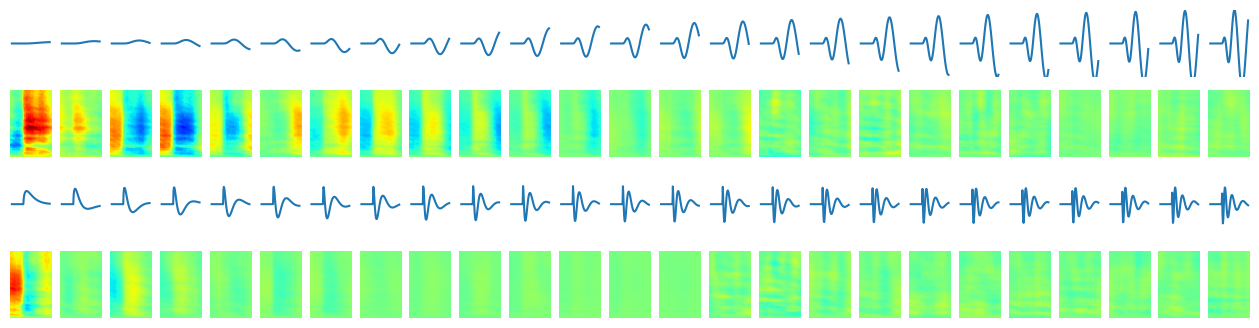

In [80]:
# Plot the On and Off filters for Laguerre Fit

plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nLaguerre, nf, nt))
strfLGOff = np.zeros((nLaguerre, nf, nt))
x_t = np.arange(nt-segmentBuffer)
x_plot = np.arange(nt)-segmentBuffer

for iL in range(nLaguerre):
    istart = 2*npcs*iL
    iend = istart+npcs
    strfLGOn[iL,:,:] = np.dot(results['Seg_Ind'][0]['weights'][istart:iend], results['pca'][0].components_).reshape((nf,nt))
    strfLGOff[iL,:,:] = np.dot(results['Seg_Ind'][0]['weights'][istart+npcs:iend+npcs], results['pca'][0].components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))
                 
for iL in range(nLaguerre):
    yOn = np.zeros(nt)
    yOn[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=results['basis_args'][0][0,0],
        alpha=results['basis_args'][0][0,1],
        xorder=iL,
        )
    # yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = np.zeros(nt)
    yOff[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=results['basis_args'][0][1,0],
        alpha=results['basis_args'][0][1,1],
        xorder=iL,
        )
    # yOff = yOff / np.sqrt(np.sum(yOff**2))
    plt.subplot(4,  nLaguerre, iL+1)
    plt.plot(x_plot,yOn)
    plt.ylim((-50,50))
    plt.axis('off')
    plt.subplot(4,  nLaguerre, 2*nLaguerre+iL+1)
    plt.plot(x_plot,yOff)
    plt.ylim((-1,1))
    plt.axis('off')
    plt.subplot(4, nLaguerre, nLaguerre+iL+1)
    plt.imshow(strfLGOn[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')
    plt.subplot(4, nLaguerre, 3*nLaguerre+iL+1)
    plt.imshow(strfLGOff[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')



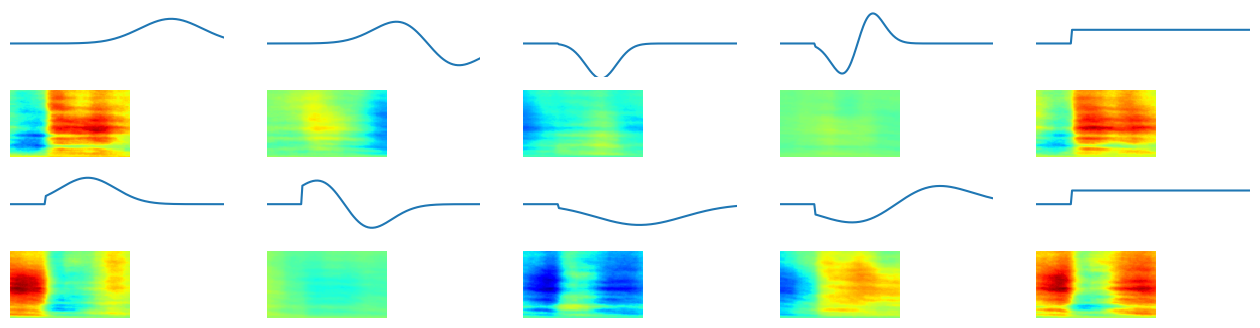

In [81]:
# Plot the On and Off filters for the DOGS Fit
nDOGS = 5
plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nDOGS, nf, nt))
strfLGOff = np.zeros((nDOGS, nf, nt))
x_t = np.arange(nPoints)
x_plot = np.arange(nPoints+segmentBuffer)-segmentBuffer


for iD in range(nDOGS):
    istart = 2*npcs*iD
    iend = istart+npcs
    strfLGOn[iD,:,:] = np.dot(results['Seg_Ind'][1]['weights'][istart:iend], results['pca'][1].components_).reshape((nf,nt))
    strfLGOff[iD,:,:] = np.dot(results['Seg_Ind'][1]['weights'][istart+npcs:iend+npcs], results['pca'][1].components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))

meanValOn, ampPosOn, ampNegOn, tPosOn, tNegOn, sdPosOn, sdNegOn = results['basis_args'][1][0]   
meanValOff, ampPosOff, ampNegOff, tPosOff, tNegOff, sdPosOff, sdNegOff = results['basis_args'][1][1]                
for iD in range(nDOGS):
    yOn = np.zeros(nPoints+segmentBuffer) 
    yOff = np.zeros(nPoints+segmentBuffer)           
    if (iD == 0) :
        yOn[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOff, sdPosOff)
    elif (iD == 1) : 
        yOn[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOff, sdPosOff)
    elif (iD == 2) : 
        yOn[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOff, sdNegOff)
    elif (iD ==3) :
        yOn[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOff, sdNegOff)
    elif (iD == 4):
        yOn[segmentBuffer:] = np.ones(nPoints)
        yOff[segmentBuffer:] = np.ones(nPoints)
    
    yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = yOff / np.sqrt(np.sum(yOff**2))

    plt.subplot(4,  nDOGS, iD+1)
    plt.plot(x_plot,yOn)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4,  nDOGS, 2*nDOGS+iD+1)
    plt.plot(x_plot,yOff)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4, nDOGS, nDOGS+iD+1)
    plt.imshow(strfLGOn[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')
    plt.subplot(4, nDOGS, 3*nDOGS+iD+1)
    plt.imshow(strfLGOff[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')



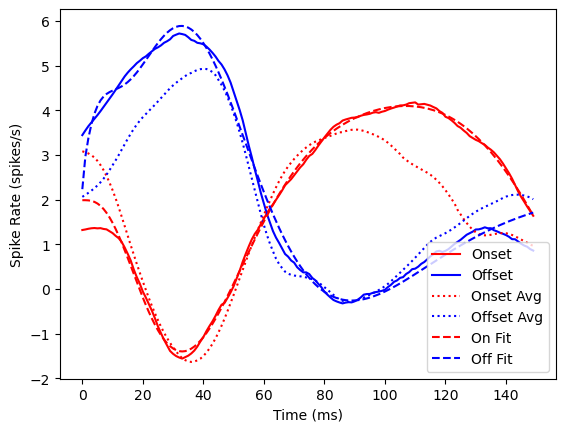

In [37]:
# Plot the segmented Kernels for this neuron and the laguerre fits
kernels = results['Seg'][0].coef_.reshape((2,nPoints))
nt = kernels.shape[1]
x_t = np.arange(nt)
laguerre_args = results['basis_args'][0]
nLGFit = laguerre_args.shape[1]-2
yOnFit = np.ones(nt)*np.mean(kernels[0,:])
for iLG in range(nLGFit):
        yOnFit += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[0,2+iLG], tau=laguerre_args[0,0], alpha=laguerre_args[0,1], xorder=iLG)

yOffFit = np.ones(nt)*np.mean(kernels[1,:])
for iLG in range(nLGFit):
        yOffFit += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[1,2+iLG], tau=laguerre_args[1,0], alpha=laguerre_args[1,1], xorder=iLG)

plt.plot(kernels[0,:], 'r', label='Onset')
plt.plot(kernels[1,:], 'b', label='Offset')
plt.plot(meansOnOff[0,:], 'r:', label='Onset Avg')
plt.plot(meansOnOff[1,:], 'b:', label='Offset Avg')
plt.plot(yOnFit, 'r--', label='On Fit')
plt.plot(yOffFit, 'b--', label='Off Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.legend()

Tau = 23.94 Alpha = 3.37


Text(0, 0.5, 'Spike Rate (spikes/s)')

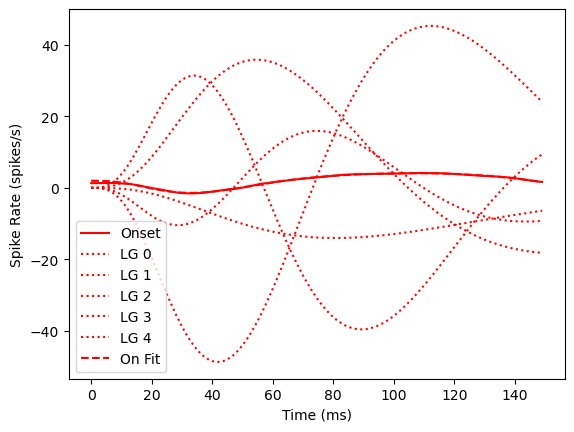

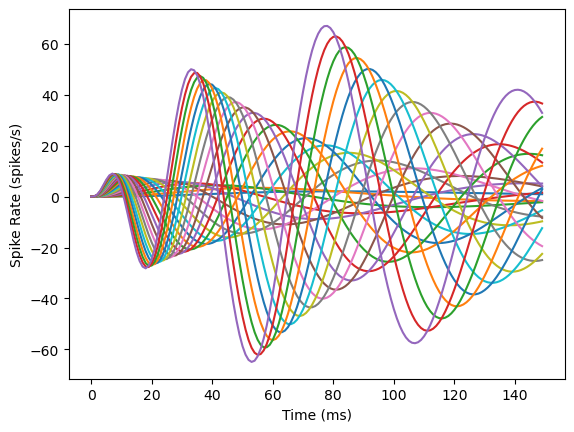

In [38]:
# Show how the fit is done
kernels = results['Seg'][0].coef_.reshape((2,nPoints))
nt = kernels.shape[1]
x_t = np.arange(nt)
laguerre_args = results['basis_args'][0]
nLGFit = laguerre_args.shape[1]-2
yOnFit = np.ones(nt)*np.mean(kernels[0,:])
plt.plot(kernels[0,:], 'r', label='Onset')
for iLG in range(nLGFit):
        yLG = calcSegmentedModel.laguerre(x_t, amp=laguerre_args[0,2+iLG], tau=laguerre_args[0,0], alpha=laguerre_args[0,1], xorder=iLG)
        yOnFit += yLG
        plt.plot(yLG, 'r:', label='LG %d'%(iLG))

plt.plot(yOnFit, 'r--', label='On Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.legend()

plt.figure()
for iL in range(nLaguerre):
    yLG = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=results['basis_args'][0][0,0],
        alpha=results['basis_args'][0][0,1],
        xorder=iL,
        )
    plt.plot(yLG)
        
print('Tau = %.2f Alpha = %.2f' % (results['basis_args'][0][0,0], results['basis_args'][0][0,1]) )
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')

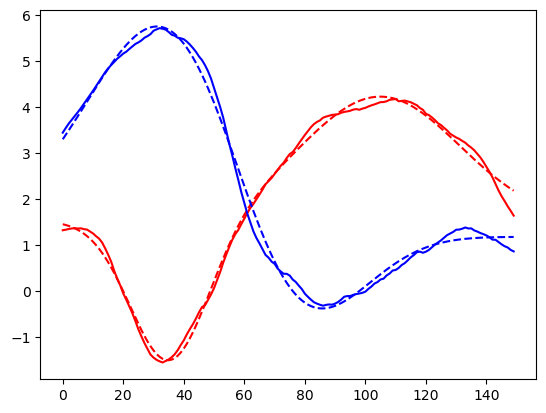

In [39]:
# Let's try fitting with DOGS.

def dogs(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = meanVal + ampPos*np.exp(-0.5*(xt-tPos)**2/sdPos**2) - ampNeg*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

def dogs_pos(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = ampPos*np.exp(-0.5*(xt-tPos)**2/sdPos**2) 
    return out

def dogs_neg(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = -ampNeg*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

def dDogsDt(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = -ampPos*((xt-tPos)/(sdPos**2))*np.exp(-0.5*(xt-tPos)**2/sdPos**2) + ampNeg*((xt-tNeg)/(sdNeg**2))*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

def dDogsDt_pos(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = -ampPos*((xt-tPos)/(sdPos**2))*np.exp(-0.5*(xt-tPos)**2/sdPos**2) 
    return out

def dDogsDt_neg(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out =  ampNeg*((xt-tNeg)/(sdNeg**2))*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

# Find starting points
meanVal = np.mean(kernels[0,:])
ampPos = np.max(kernels[0,:])-meanVal
tPos = np.argmax(kernels[0,:])
ampNeg = np.abs(np.min(kernels[0,:])-meanVal)
tNeg = np.argmin(kernels[0,:])
sdPos = sdNeg = 20
p0=[meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg]



poptOn, pcovOn = curve_fit(
            dogs,
            np.arange(nt), kernels[0,:], p0,
            bounds=(
                [np.min(kernels[0,:]), 0, 0, 0, 0, 0, 0],
                [np.max(kernels[0,:]), np.inf, np.inf, nt, nt, nt, nt],
            ),
            method="trf",
        )
yOnDOGFit = dogs(np.arange(nt), *poptOn)
yOnDDOGFit = dDogsDt(np.arange(nt), *poptOn)

meanVal = np.mean(kernels[1,:])
ampPos = np.max(kernels[1,:])-meanVal
tPos = np.argmax(kernels[1,:])
ampNeg = np.abs(np.min(kernels[1,:])-meanVal)
tNeg = np.argmin(kernels[1,:])
sdPos = sdNeg = 20
p0=[meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg]



poptOff, pcovOff = curve_fit(
            dogs,
            np.arange(nt), kernels[1,:], p0,
            bounds=(
                [np.min(kernels[1,:]), 0, 0, 0, 0, 0, 0],
                [np.max(kernels[1,:]), np.inf, np.inf, nt, nt, nt, nt],
            ),
            method="trf",
        )
yOffDOGFit = dogs(np.arange(nt), *poptOff)
yOffDDOGFit = dDogsDt(np.arange(nt), *poptOff)

plt.figure()
plt.plot(kernels[0,:], 'r', label='Onset')
plt.plot(yOnDOGFit, 'r--', label='On Fit')
# plt.plot(10.0*yOnDDOGFit, 'r:', label='On Derivative')
plt.plot(kernels[1,:], 'b', label='Offset')
plt.plot(yOffDOGFit, 'b--', label='Off Fit')
# plt.plot(10.0*yOffDDOGFit, 'b:', label='Off Derivative')



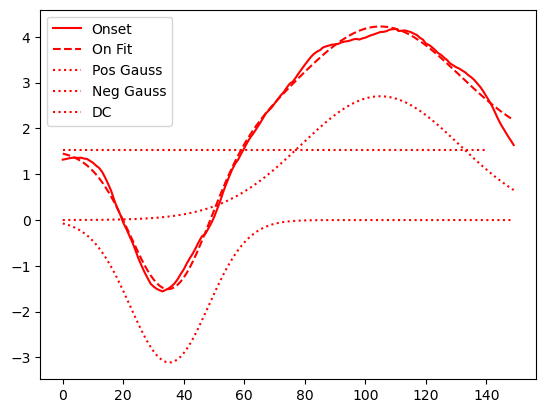

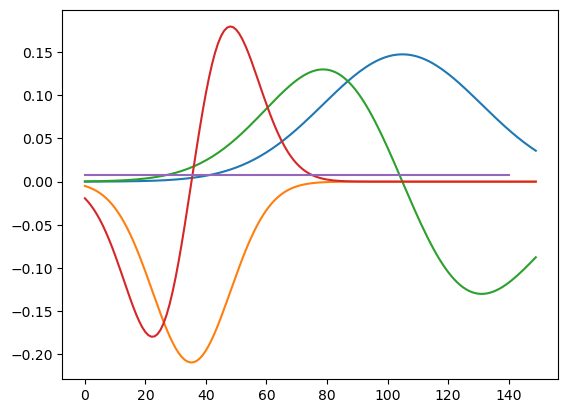

In [40]:
plt.figure()
plt.plot(kernels[0,:], 'r', label='Onset')
plt.plot(yOnDOGFit, 'r--', label='On Fit')
plt.plot(dogs_pos(np.arange(nt), *poptOn), 'r:', label='Pos Gauss')
plt.plot(dogs_neg(np.arange(nt), *poptOn), 'r:', label='Neg Gauss')
plt.plot([0, 140], [poptOn[0], poptOn[0]], 'r:', label='DC')
plt.legend()


plt.figure()
x = dogs_pos(np.arange(nt), *poptOn)
x /= np.sqrt(np.sum(x**2))
plt.plot(x)
x = dogs_neg(np.arange(nt), *poptOn)
x /= np.sqrt(np.sum(x**2))
plt.plot(x)
x = dDogsDt_pos(np.arange(nt), *poptOn)
x /= np.sqrt(np.sum(x**2))
plt.plot(x)
x = dDogsDt_neg(np.arange(nt), *poptOn)
x /= np.sqrt(np.sum(x**2))
plt.plot(x)
plt.plot([0, 140], [1/140, 1/140])



/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_15671/2869935386.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))


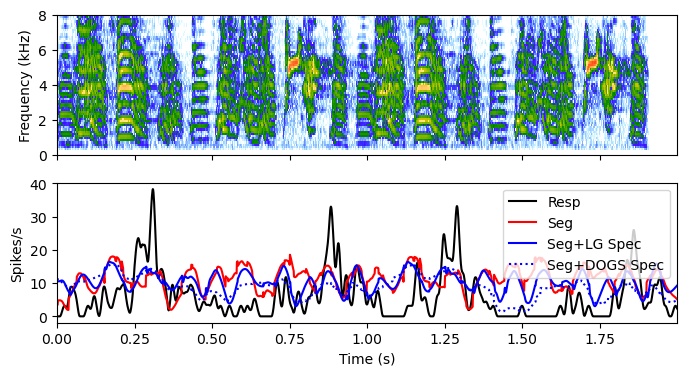

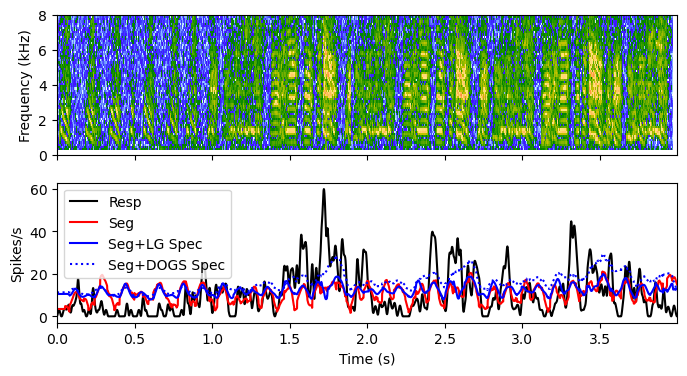

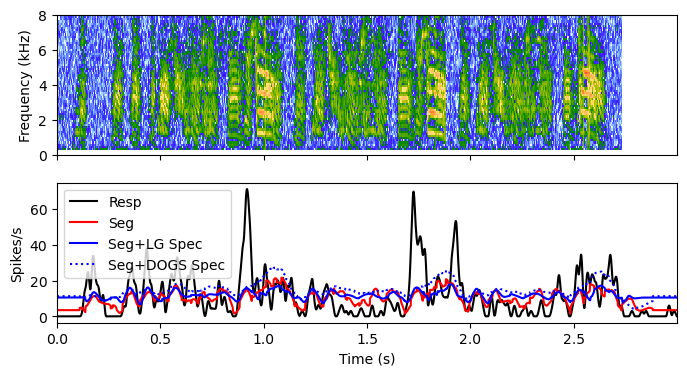

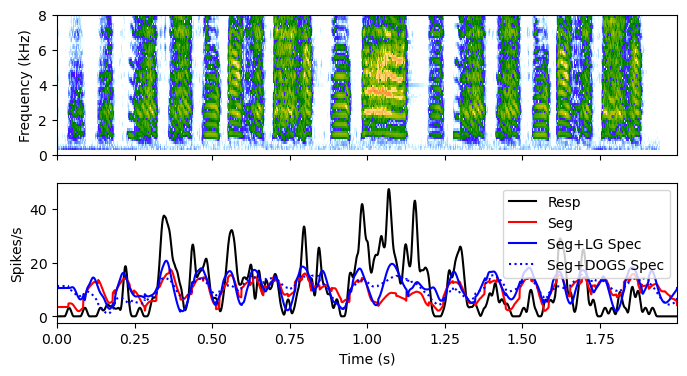

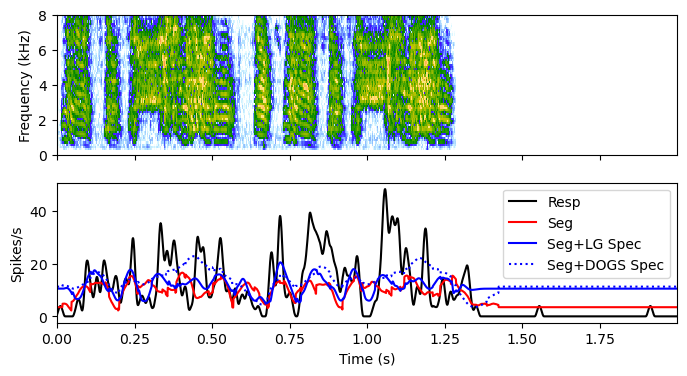

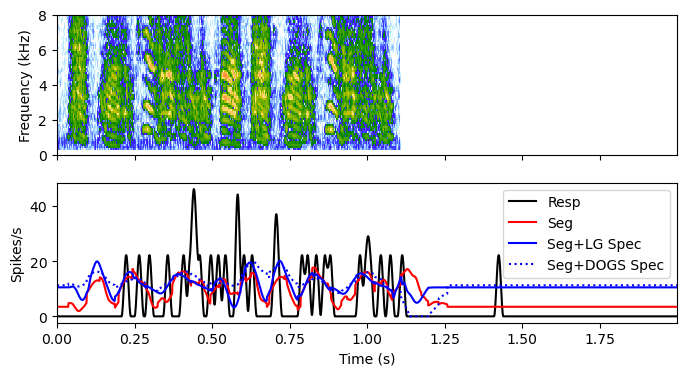

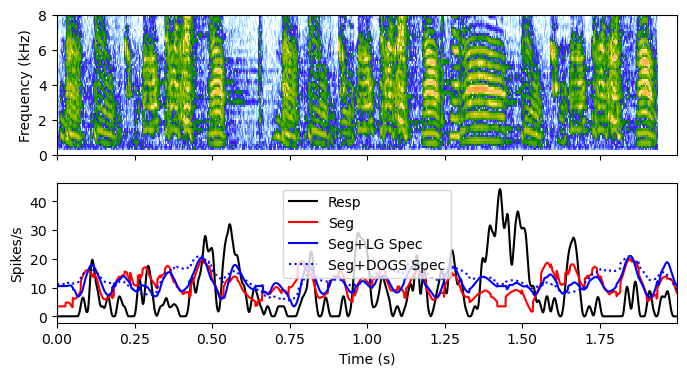

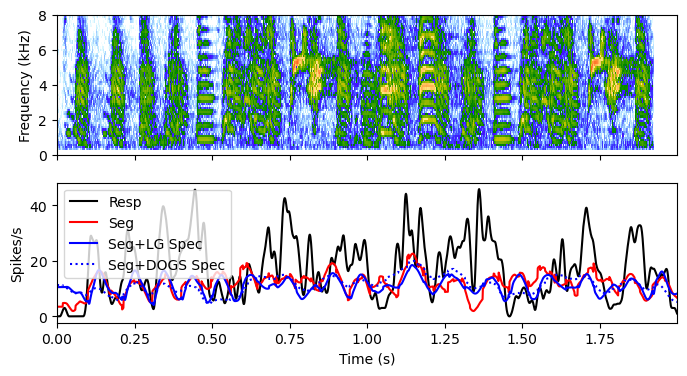

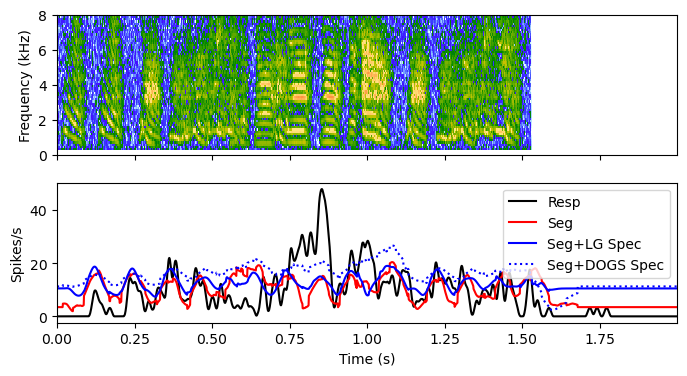

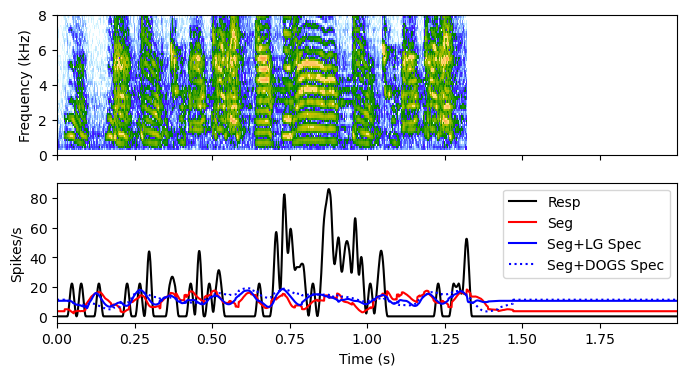

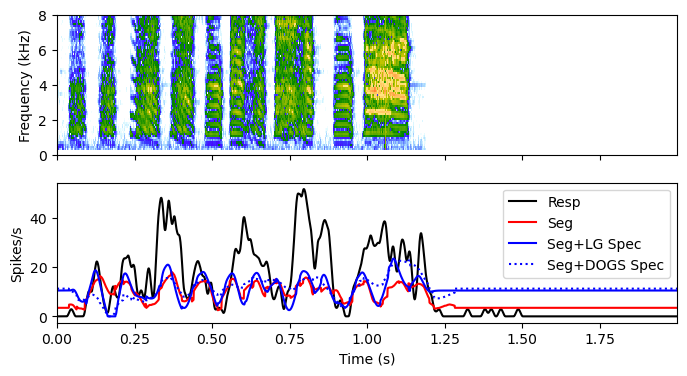

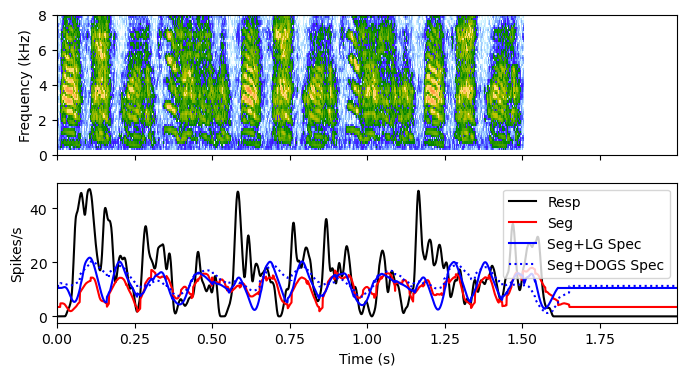

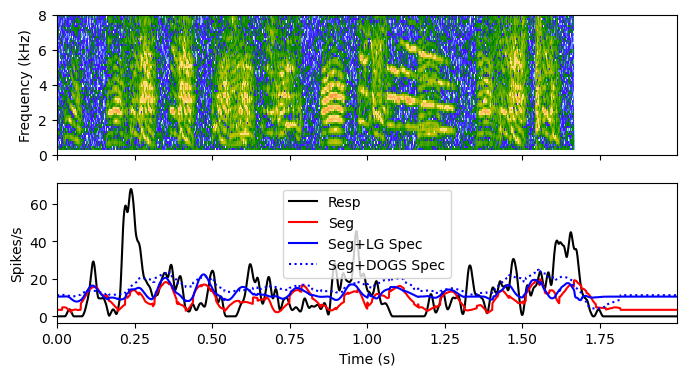

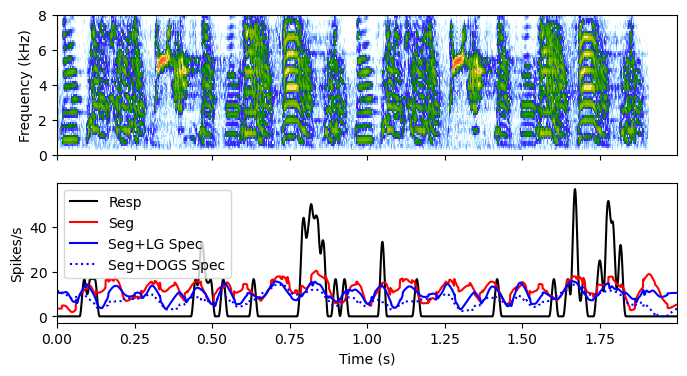

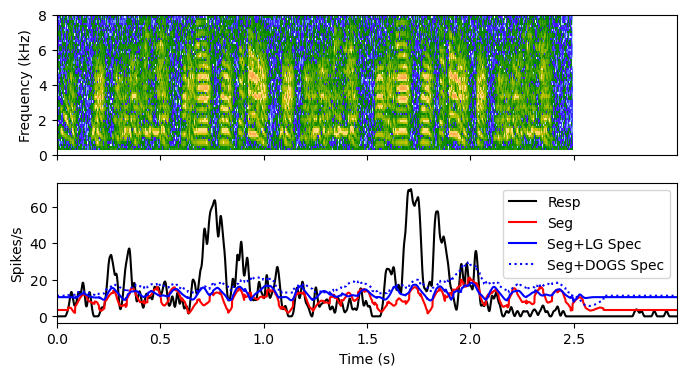

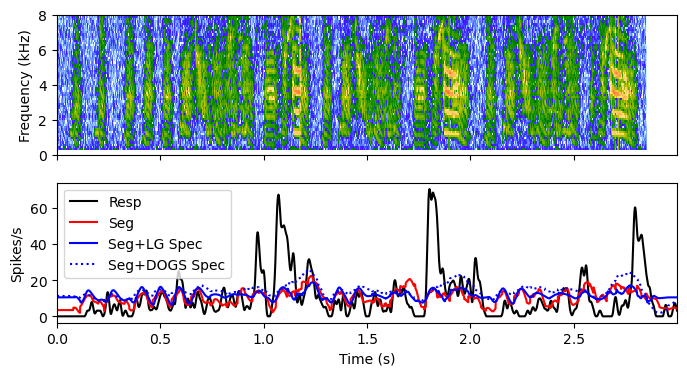

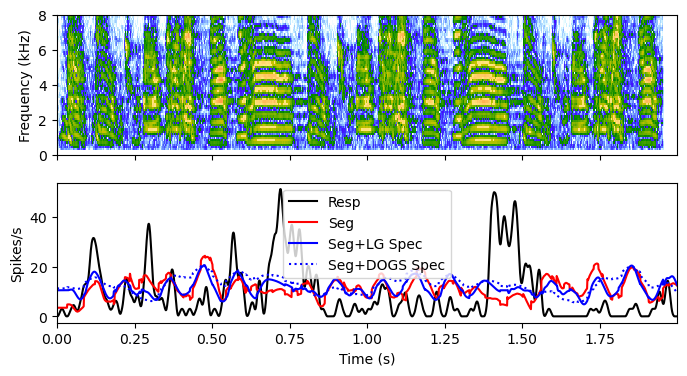

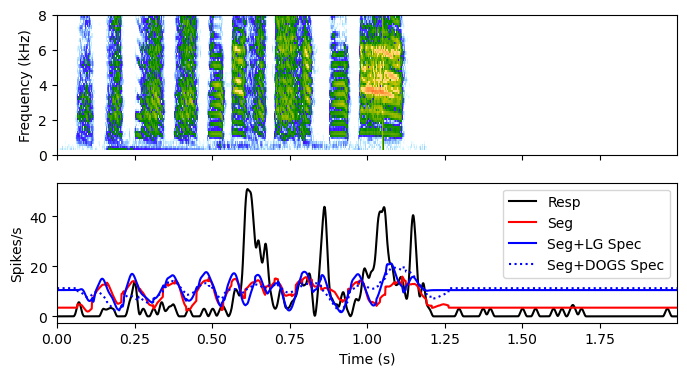

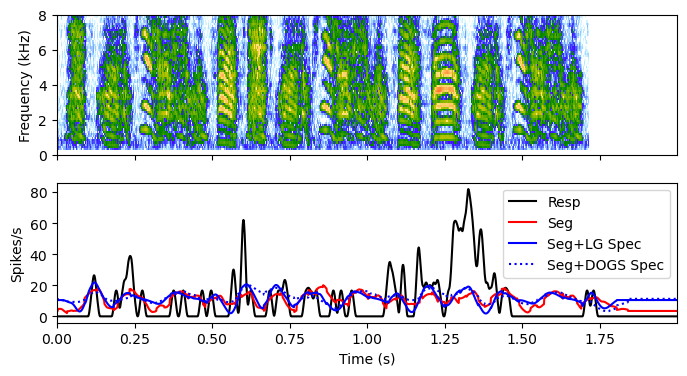

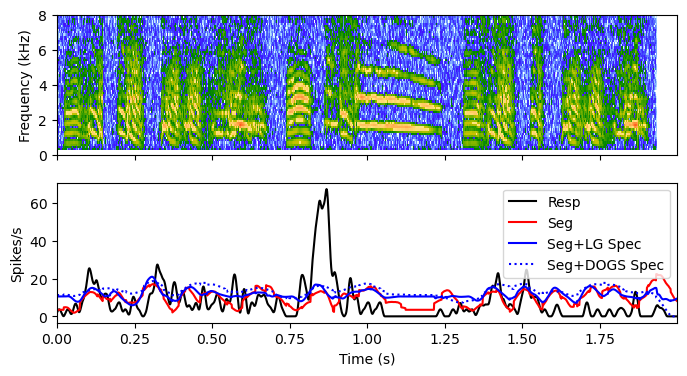

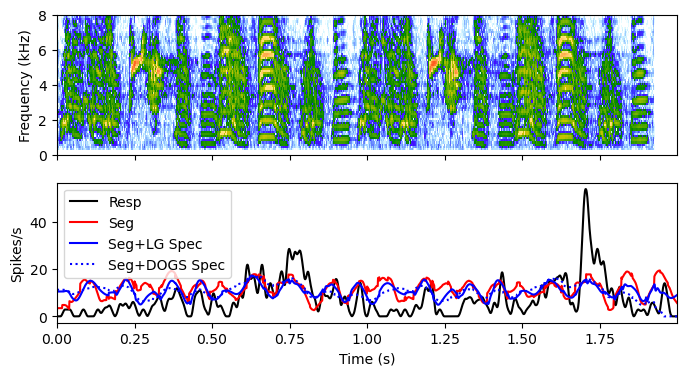

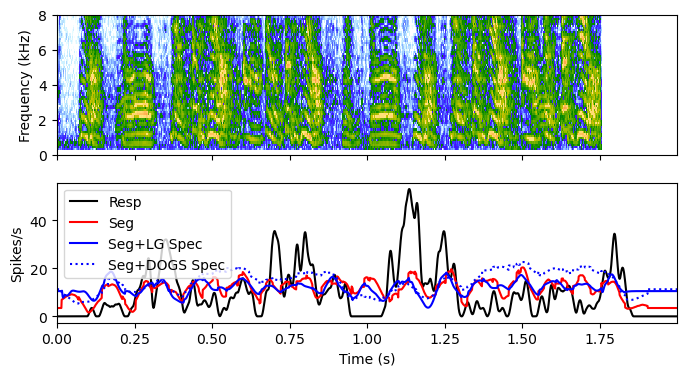

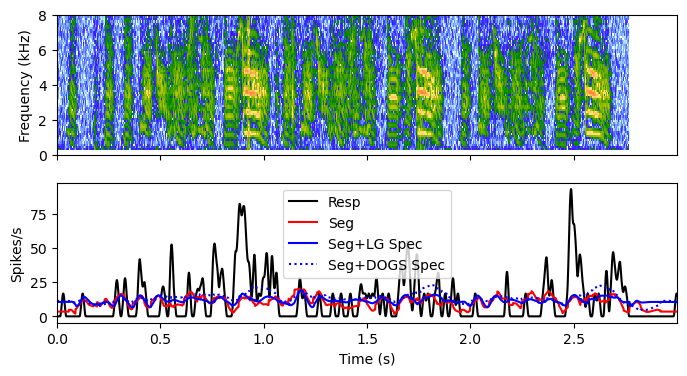

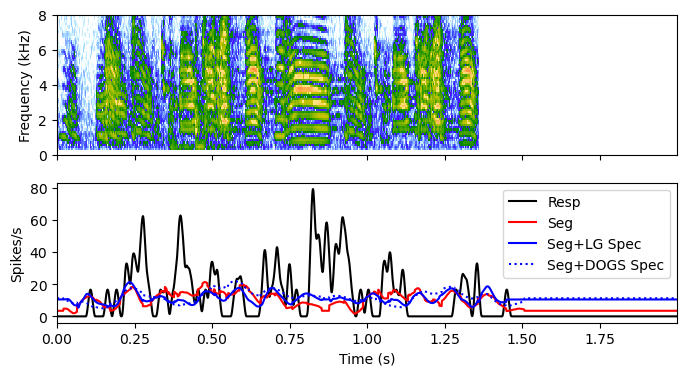

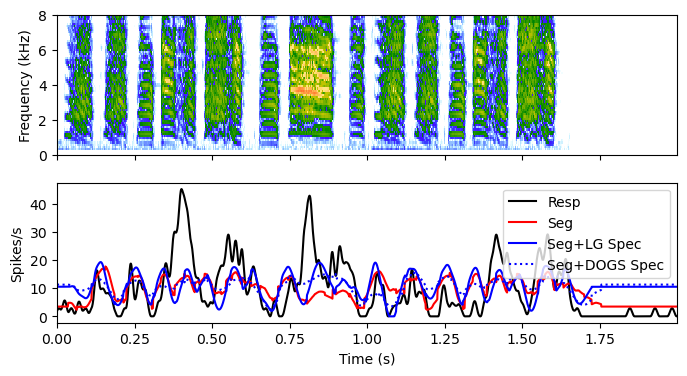

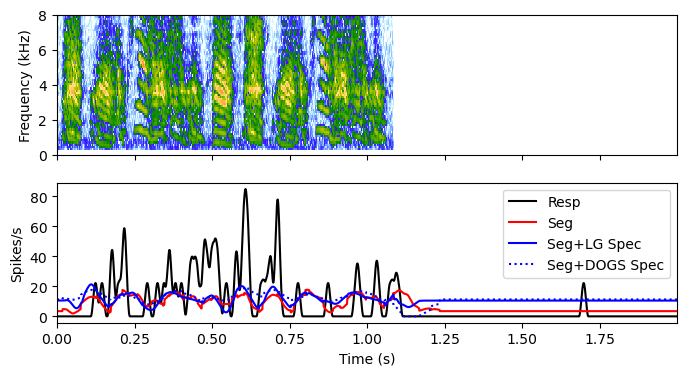

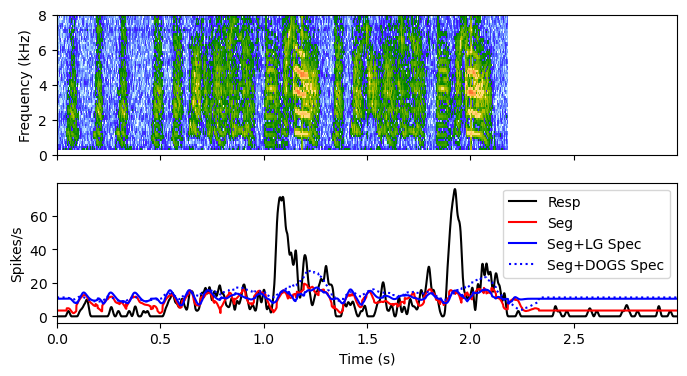

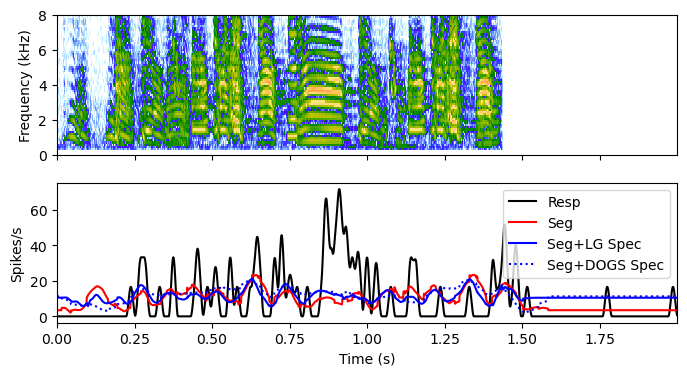

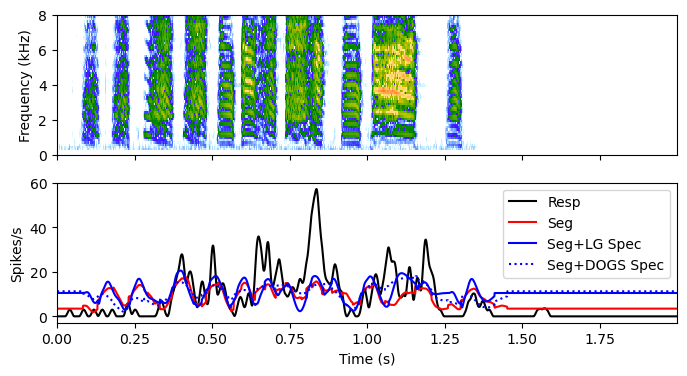

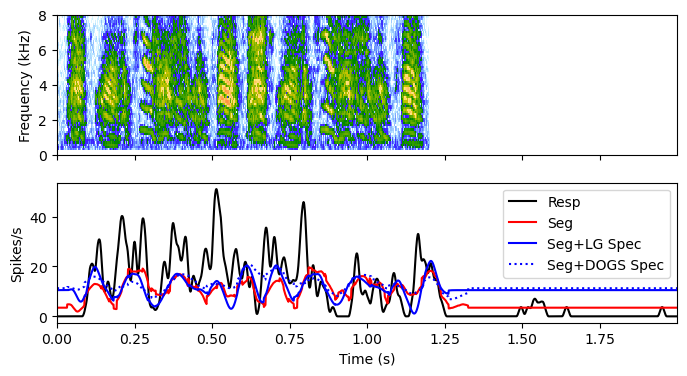

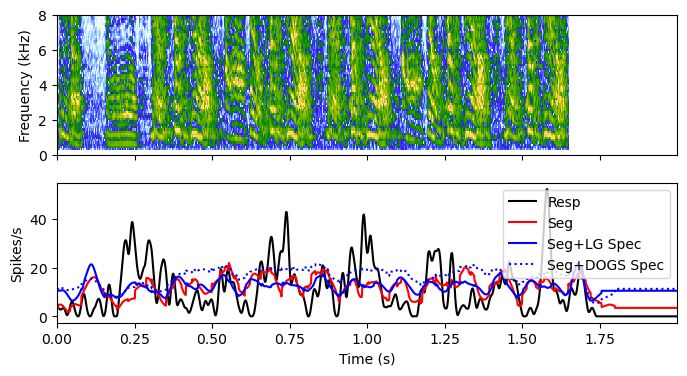

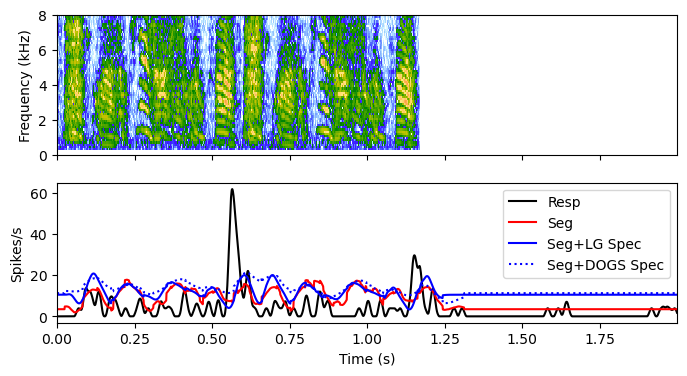

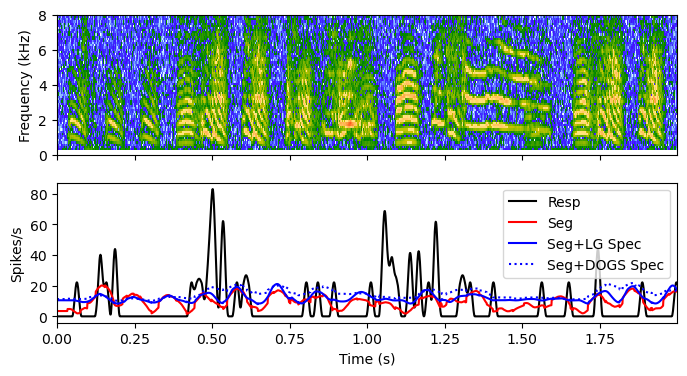

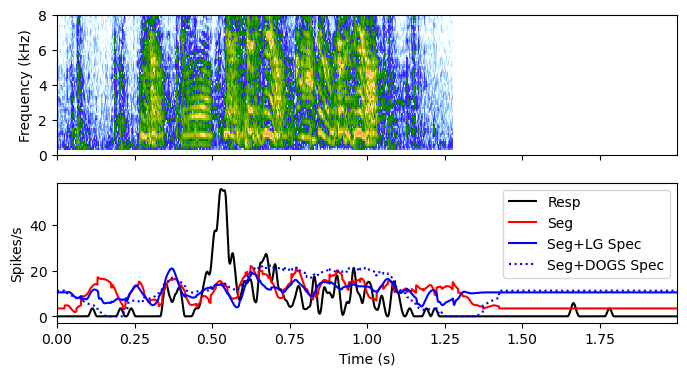

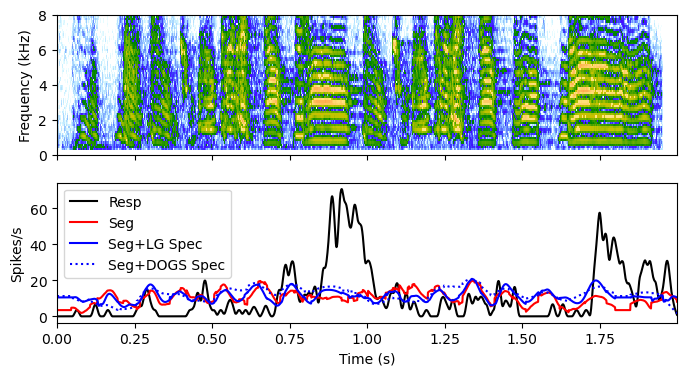

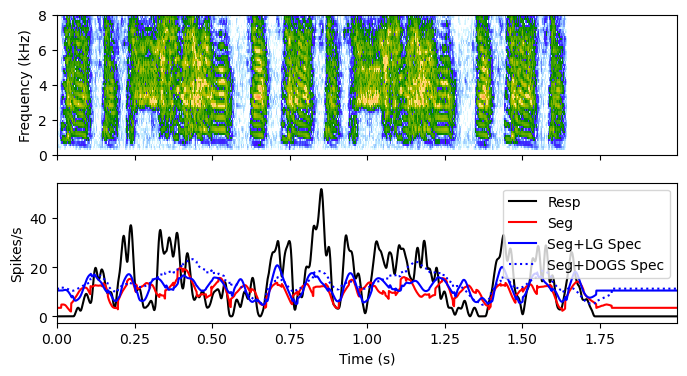

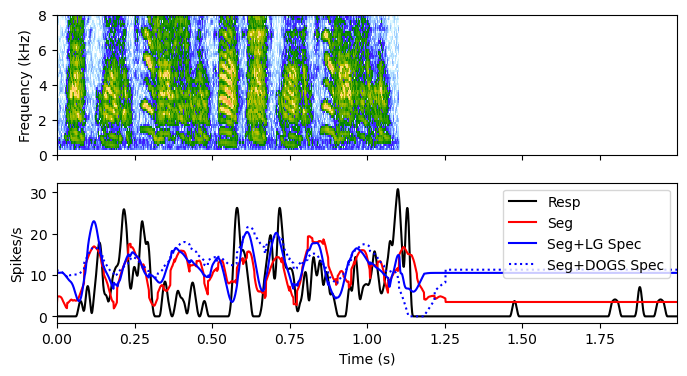

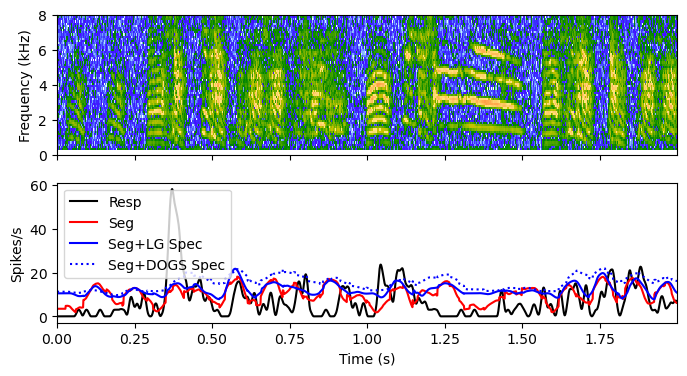

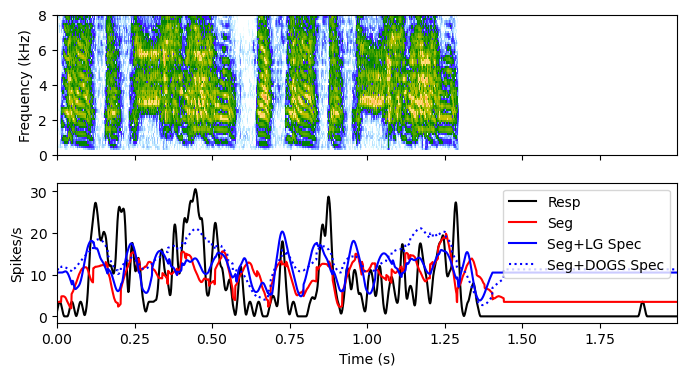

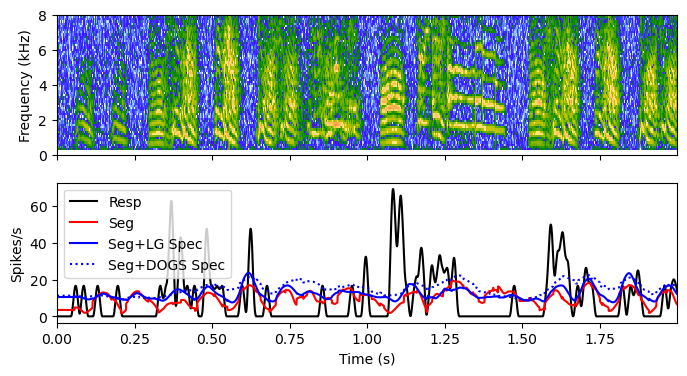

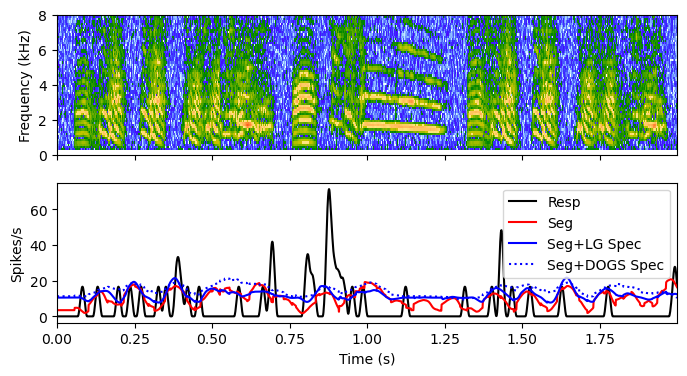

In [82]:
# Show all the results
DBNOISE = 80 # should match value in preprocSound
for pair in srData['datasets']:

    y = pair['resp']['psth_smooth']

    # get the pred for the seg only version
    x = calcSegmentedModel.arbitrary_kernel(pair, nPoints=nPoints, resp_key='psth')
    y_pred_1 = results['Seg'][0].predict(x.T)


    # get the pred for the full version
    y_pred_2 = calcSegmentedModel.generate_predictionV2(
        pair, results['Seg_Ind'][0], feature, results['basis_args'][0], nPoints, nLaguerre
    )
    y_pred_3 = calcSegmentedModel.generate_predictionV2(
        pair, results['Seg_Ind'][1], feature, results['basis_args'][1], nPoints, -1
    )

    
    # The spectrogram
    tfrep = pair['stim']['tfrep']
    minSpect = 0
    maxB = DBNOISE

    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # ax1.set_xlabel('Time (s)')

    # The prediction
    numTrials = len(pair['resp']['rawSpikeTimes'])
    # fac = pair['resp']['sampleRate']/numTrials   # The psth and the responses are already normalized in preprocSound.py
    ax2.plot(tfrep['t'], y, 'k', label='Resp')
    ax2.plot(tfrep['t'], y_pred_1, 'r', label='Seg')
    ax2.plot(tfrep['t'], y_pred_2.T, 'b', label='Seg+LG Spec')
    ax2.plot(tfrep['t'], y_pred_3.T, 'b:', label='Seg+DOGS Spec')
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    plt.legend()

